### 第一个回归问题 —— 预测燃油效率

loss = mse (Not cross_entropy)
不需要输出单元
metrics = ['mae']
features/labels:气缸数，排量，马力以及重量。

In [84]:
import tensorflow as tf
import matplotlib.pyplot as plt

# pandas处理数据
import pandas as pd
# seaborn也是画图
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

In [85]:
# Auto MPG dataset. csv file.
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

# 使用 pandas 导入数据集
# desc / features / labels
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path,
                          names=column_names,
                          na_values="?",
                          comment='\t',
                          sep=" ",
                          skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail(n=5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [86]:
# 数据清洗
dataset.isna().sum()
dataset = dataset.dropna()

# origin的数字代表国家，转为独热编码(向量)
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail(n=5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [87]:
# 80%训练集， 20%测试集
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

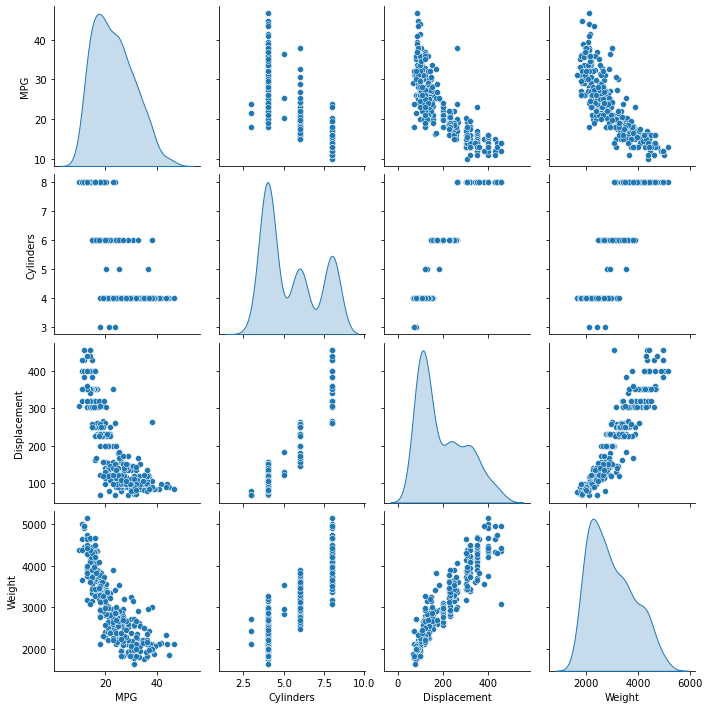

In [88]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [89]:
# Math DESC
stats = train_dataset.describe()
stats.pop('MPG')
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 从标签中分离特征

将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值。

In [90]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [91]:
# 数据归一化
def normalize(data):
    return (data - stats['mean']) / stats['std']


normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

#### 模型

In [92]:
def build_model():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    # default
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  # todo mae??
                  metrics=['mae', 'mse'])
    return model


model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [93]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    # 接收 tf.keras.callbacks 中的(一个或多个)类
    callbacks=[PrintDot()])

2021-08-11 19:43:31.750794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-11 19:43:31.957996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [94]:
hist = pd.DataFrame(history.history)
hist.tail(n=5)

,loss,mae,mse,val_loss,val_mae,val_mse
995,2.825262,1.054172,2.825262,9.326747,2.327448,9.326747
996,2.830466,1.044409,2.830466,9.104322,2.317285,9.104322
997,2.659493,1.033758,2.659493,9.256103,2.331395,9.256103
998,2.533640,0.967859,2.533640,9.473487,2.296917,9.473487
999,2.780305,1.047870,2.780305,9.156223,2.287871,9.156223


#### 画图

In [95]:
def plot_history(history):
    hist_dict = history.history
    # dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])
    hist_dict.keys()

    mae = hist_dict['mae']
    val_mae = hist_dict['val_mae']
    mse = hist_dict['mse']
    val_mse = hist_dict['val_mse']
    loss = hist_dict['loss']
    val_loss = hist_dict['val_loss']

    epochs = range(1, len(mae) + 1)

    # plot mae
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(epochs, mae,
             label='Train Error')
    plt.plot(epochs, val_mae,
             label='Val Error')
    plt.legend()
    plt.ylim([0, 5])
    plt.show()

    # plot mse
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(epochs, mse,
             label='Train Error')
    plt.plot(epochs, val_mse,
             label='Val Error')
    plt.legend()
    plt.ylim([0, 20])
    plt.show()

    # plot loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, loss, label='Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.legend()
    plt.ylim([0, 20])
    plt.show()

3/3 [==============================] - 0s 84ms/step - loss: 7.7703 - mae: 2.2618 - mse: 7.7703


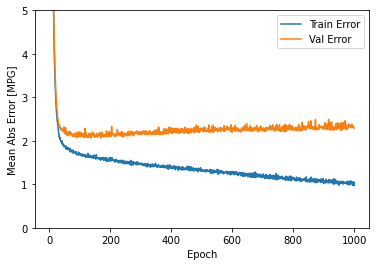

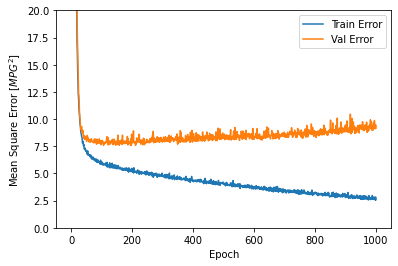

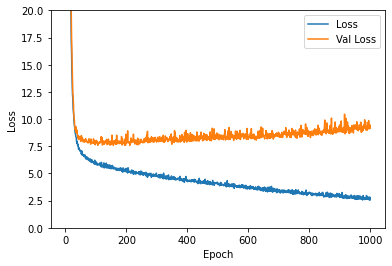

In [96]:
model.evaluate(normed_test_data, test_labels)
plot_history(history)

该图表显示在约 100 个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。

我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。

In [97]:
# patience 次训练后没有改进，则提前停止。
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = build_model()
history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS,
                    # 20%的训练数据作为验证集
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop])

2021-08-11 19:44:35.901803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-11 19:44:36.042268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 6ms/step - loss: 5.3844 - mae: 1.8013 - mse: 5.3844


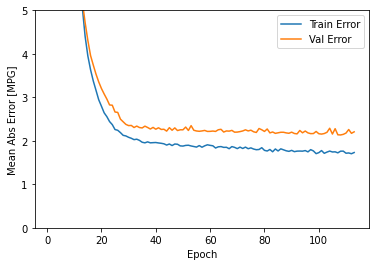

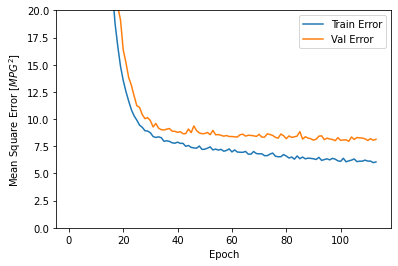

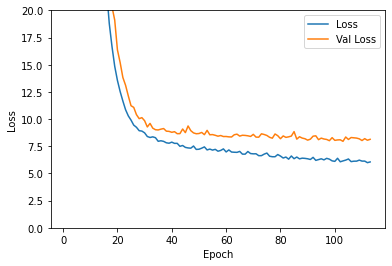

In [98]:
model.evaluate(normed_test_data, test_labels)
plot_history(history)

2021-08-11 19:48:22.188405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


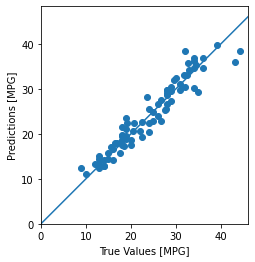

In [99]:
# 使用测试集中的数据预测 MPG 值
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

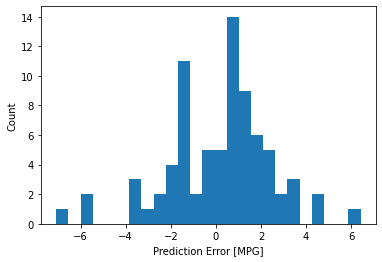

In [100]:
# 误差分布
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布(正态分布)，但我们可以推断出，这是因为样本的数量很小所导致的。

#### 结论

本笔记本 (notebook) 介绍了一些处理回归问题的技术。

- 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。
- 类似的，用于回归的评估指标与分类不同。 常见的回归指标是**平均绝对误差**（MAE）。
- 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
- 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
- 早期停止是一种防止过度拟合的有效技术。

